In [1]:
%matplotlib inline

from collections import namedtuple, deque
from itertools import count
import random

import gym
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T

In [2]:
env = gym.make("CartPole-v0").unwrapped

In [17]:
env.close()

In [4]:
num_episodes = 4

for episode in range(num_episodes):

    observation = env.reset()
    
    print("Starting episode", episode)

    for t in count():

        env.render()

        action = env.action_space.sample()

        observation, reward, complete, info = env.step(action)

        if complete:
            break

env.close()

Starting episode 0
Starting episode 1
Starting episode 2
Starting episode 3


(800, 1200, 3)


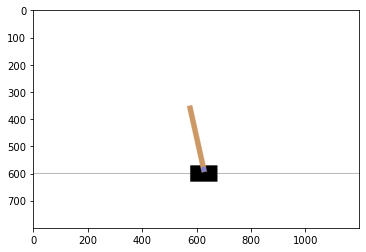

In [5]:
frame = env.render(mode="rgb_array")
env.close()

print(frame.shape)

plt.imshow(frame)

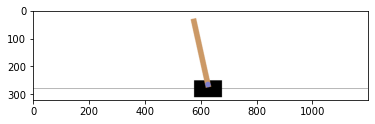

In [6]:
fheight, fwidth, _ = frame.shape

cheight_min = int(fheight * 0.4)
cheight_max = int(fheight * 0.8)

frame_cropped = frame[cheight_min:cheight_max, :, :]

plt.imshow(frame_cropped)

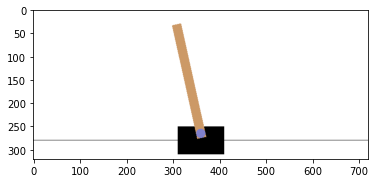

In [7]:
cwidth = int(fwidth * 0.6)

ewidth = env.x_threshold * 2
width_scale = fwidth / ewidth

epos = env.state[0]
spos = int(epos * width_scale + fwidth / 2)
spos

cwidth_min = spos - cwidth // 2
cwidth_max = spos + cwidth // 2

frame_cropped = frame[cheight_min:cheight_max, cwidth_min:cwidth_max,:]

plt.imshow(frame_cropped)

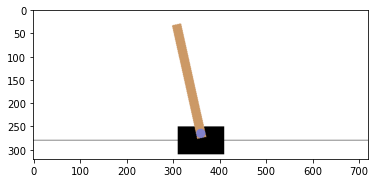

In [8]:
frame_cropped_float = frame_cropped / 255
# frame_cropped_float = np.ascontiguousarray(frame_cropped, dtype=np.float32) / 255
frame_cropped_float = torch.from_numpy(frame_cropped_float)
plt.imshow(frame_cropped_float)
# frame_cropped_float[0:5, 0:5, :]

In [9]:
s = frame_cropped_float.permute(2, 0, 1)

xform = T.Compose([T.ToPILImage(), T.Resize(40, interpolation=Image.CUBIC), T.ToTensor()])
x = xform(s)

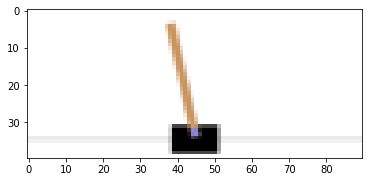

In [10]:
plt.imshow(x.permute(1, 2, 0).numpy())

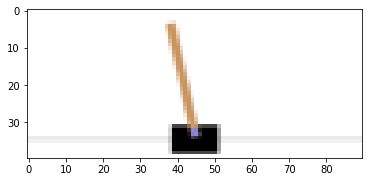

In [12]:
new_height = 40

resize = T.Compose(
    [T.ToPILImage(), T.Resize(new_height, interpolation=Image.CUBIC), T.ToTensor()]
)


def prepare_frame(frame):
    fheight, fwidth, _ = frame.shape

    cheight_min = int(fheight * 0.4)
    cheight_max = int(fheight * 0.8)

    cwidth = int(fwidth * 0.6)

    ewidth = env.x_threshold * 2
    width_scale = fwidth / ewidth

    epos = env.state[0]
    spos = int(epos * width_scale + fwidth / 2)

    cwidth_min = spos - cwidth // 2
    cwidth_max = spos + cwidth // 2

    cframe = frame[cheight_min:cheight_max, cwidth_min:cwidth_max, :]
    tframe = torch.from_numpy(cframe / 255).permute(2, 0, 1)
    
    return resize(tframe).unsqueeze(0)

plt.imshow(prepare_frame(frame).squeeze().permute(1, 2, 0).numpy());

In [13]:
env.action_space

Discrete(2)

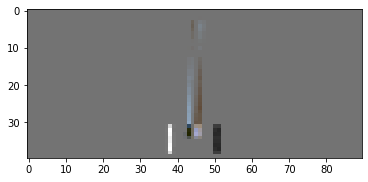

In [15]:
env.reset()
frame1 = env.render(mode="rgb_array")
env.step(1)
env.step(1)
env.step(1)
env.step(1)
frame2 = env.render(mode="rgb_array")
env.close()

pframe1 = prepare_frame(frame1)
pframe2 = prepare_frame(frame2)

state = pframe2 - pframe1
state += state.min().abs()
state /= state.max()

plt.imshow(state.squeeze().permute(1, 2, 0).numpy())

In [25]:
num_episodes = 4

for episode in range(num_episodes):

    env.reset()
    prev_frame = prepare_frame(env.render(mode="rgb_array"))
    curr_frame = prev_frame
    state = curr_frame - prev_frame
    
    print("Starting episode", episode)

    for t in count():

        # How do we choose an action?
#         action = ...

#         _, reward, complete, _ = env.step(action)
        
        prev_frame = curr_frame
        curr_frame = env.render(mode="rgb_array")
        
        # How do we optimize?

        if complete:
            break

env.close()

Starting episode 0
Starting episode 1
Starting episode 2
Starting episode 3


In [26]:
def conv_output_size(size, kernel_size, stride):
    return (size - (kernel_size - 1) - 1) // stride + 1


class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()

        F = 5
        S = 2

        K0 = 3
        K1 = 16
        self.conv1 = nn.Conv2d(K0, K1, kernel_size=F, stride=S)
        self.bn1 = nn.BatchNorm2d(K1)

        h1 = conv_output_size(h, F, S)
        w1 = conv_output_size(w, F, S)

        K2 = 32
        self.conv2 = nn.Conv2d(K1, K2, kernel_size=F, stride=S)
        self.bn2 = nn.BatchNorm2d(K2)

        h2 = conv_output_size(h1, F, S)
        w2 = conv_output_size(w1, F, S)

        K3 = 32
        self.conv3 = nn.Conv2d(K2, K3, kernel_size=F, stride=S)
        self.bn3 = nn.BatchNorm2d(K3)

        h3 = conv_output_size(h2, F, S)
        w3 = conv_output_size(w2, F, S)

        linear_input_size = h3 * w3 * 32
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [27]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

In [28]:
frame = prepare_frame(env.render(mode="rgb_array"))
env.close()
_, _, fheight, fwidth = frame.shape

num_actions = env.action_space.n

policy = DQN(fheight, fwidth, num_actions)
policy_stable = DQN(fheight, fwidth, num_actions)
policy_stable.load_state_dict(policy.state_dict())
policy_stable.eval()

optimizer = optim.RMSprop(policy.parameters())
criterion = nn.SmoothL1Loss()

In [29]:
def select_action(policy, state, step, num_actions):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1.0 * step / EPS_DECAY)
    step += 1
    r = random.random()
    if r > eps_threshold:
        with torch.no_grad():
            return policy(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(num_actions)]], dtype=torch.long)

In [30]:
select_action(policy, state, 100, 2)

tensor([[1]])

In [31]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [45]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE)
    next_state_values[non_final_mask] = policy_stable(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    for param in policy.parameters():
        param.grad.data.clamp_(-1, 1)
    
    optimizer.step()

In [47]:
num_episodes = 12
step = 0

memory = ReplayMemory(10000)

for episode in range(num_episodes):
    
    env.reset()
    prev_frame = prepare_frame(env.render(mode="rgb_array"))
    curr_frame = prev_frame
    state = curr_frame - prev_frame
    
    print("Starting episode", episode)
    
    for t in count():
        
        action = select_action(policy, state, step, num_actions)
        
        _, reward, complete, _ = env.step(action.item())
        
        reward = torch.tensor([reward])

        # Observe new state
        prev_frame = curr_frame
        curr_frame = prepare_frame(env.render(mode="rgb_array"))
        
        # Treat the final state differently
        if not complete:
            next_state = curr_frame - prev_frame
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        optimize_model()

        if complete:
            break

    # Update the stable network, copying all weights and biases in DQN
    if episode % TARGET_UPDATE == 0:
        policy_stable.load_state_dict(policy.state_dict())

print('Complete')
env.close()

Starting episode 0
Starting episode 1
Starting episode 2
Starting episode 3
Starting episode 4
Starting episode 5
Starting episode 6
Starting episode 7
Starting episode 8
Starting episode 9
Starting episode 10
Starting episode 11
Complete
